# 1. Exploratory Data Analysis

In [1]:
# Import libraries

# Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plotting
import seaborn as sns

# Mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [2]:
# load the data
df = pd.read_csv("titanic.csv")

In [3]:
# Viewing the top 5 rows
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Display shape of data frame
df.shape

(891, 12)

# 2. Data Cleaning/Preparation

In [5]:
# Check if there are NaN values
X = df
X.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Binning Age

bins= [-1,0,21,60,110]
labels = ['Unknown','Child','Adult','Senior']
X['Age'] = pd.cut(X['Age'], bins=bins, labels=labels, right=False)

In [7]:
# Fill NA of Age, Embarked & Cabin

X['Age'] = X['Age'].fillna("Unknown")
X['Embarked'] = X['Embarked'].fillna("Unknown")

In [8]:
# Replace Survived = 1,0 

X['Survived'].replace({0: 'Died', 1: 'Survived'},inplace = True)

In [9]:
# Drop Unnecessary Columns
X = X.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'PassengerId'], axis = 1)

In [10]:
# Observing Distribution of Age

X['Age'].value_counts()

Adult      508
Child      180
Unknown    177
Senior      26
Name: Age, dtype: int64

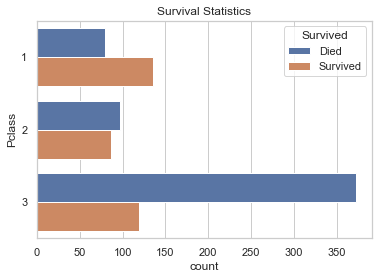

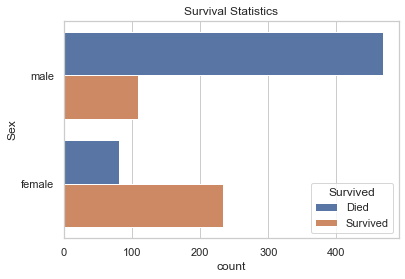

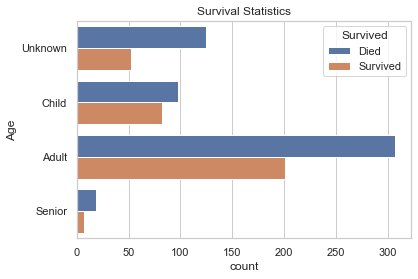

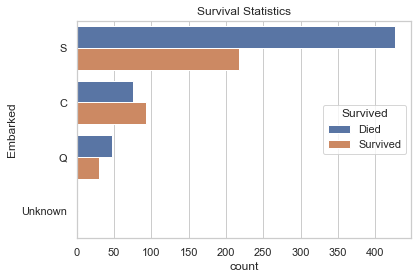

In [11]:
# Create Plot

for x in ['Pclass', 'Sex','Age', 'Embarked']:
    sns.set(style="whitegrid")
    ax = sns.countplot(y=x, hue="Survived", data=X)
    plt.ylabel(x)
    plt.title('Survival Statistics')
    plt.show()

# 3. Association Rule Learning with Apriori Algorithm

In [12]:
# Create another df with all the attributes

titanic_set = []
for i in range(0, X.shape[0]-1):
    titanic_set.append([str(X.values[i,j]) for j in range(0, X.shape[1])])

titanic_sm = TransactionEncoder()
titanic_sm_ary = titanic_sm.fit(titanic_set).transform(titanic_set)
df1 = pd.DataFrame(titanic_sm_ary, columns=titanic_sm.columns_)
df1.head()

,1,2,3,Adult,C,Child,Died,Q,S,Senior,Survived,Unknown,female,male
0,False,False,True,True,False,False,True,False,True,False,False,False,False,True
1,True,False,False,True,True,False,False,False,False,False,True,False,True,False
2,False,False,True,True,False,False,False,False,True,False,True,False,True,False
3,True,False,False,True,False,False,False,False,True,False,True,False,True,False
4,False,False,True,True,False,False,True,False,True,False,False,False,False,True


In [13]:
# Create Apriori Set

df1_ap = apriori(df1, min_support=0.05, use_colnames=titanic_sm.columns_)
df1_ap.head()

,support,itemsets
0,0.242697,(1)
1,0.206742,(2)
2,0.550562,(3)
3,0.569663,(Adult)
4,0.188764,(C)


In [14]:
# Build Association Rule

rules = association_rules(df1_ap, metric="lift", min_threshold=1)  # setting the threshold of Lift Value as 1.
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1),(Adult),0.242697,0.569663,0.166292,0.685185,1.202791,0.028037,1.366953
1,(Adult),(1),0.569663,0.242697,0.166292,0.291913,1.202791,0.028037,1.069506
2,(C),(1),0.188764,0.242697,0.095506,0.505952,2.084711,0.049693,1.532855
3,(1),(C),0.242697,0.188764,0.095506,0.393519,2.084711,0.049693,1.337610
4,(Survived),(1),0.384270,0.242697,0.152809,0.397661,1.638510,0.059548,1.257271


# 4. Data Visualisation

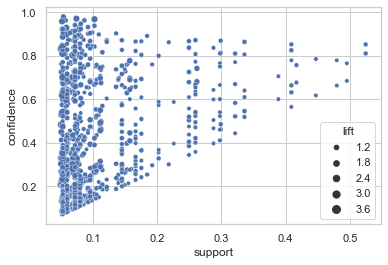

In [15]:
# Generate scatterplot using support and confidence
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.show()

In [20]:
rules[(rules['confidence'] >= 0.8)].sort_values(by='confidence', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
211,"(Q, Unknown)",(3),0.055056,0.550562,0.053933,0.979592,1.779259,0.023621,22.022472
361,"(female, 1, Adult)",(Survived),0.076404,0.384270,0.074157,0.970588,2.525800,0.044797,20.934831
100,"(female, 1)",(Survived),0.105618,0.384270,0.102247,0.968085,2.519286,0.061661,19.292884
89,"(Died, 1)",(male),0.089888,0.647191,0.086517,0.962500,1.487196,0.028342,9.408240
373,"(Died, S, 1)",(male),0.059551,0.647191,0.057303,0.962264,1.486832,0.018763,9.349438
...,...,...,...,...,...,...,...,...,...
154,"(2, Survived)",(female),0.097753,0.352809,0.078652,0.804598,2.280548,0.044164,3.312095
106,"(2, Died)",(Adult),0.108989,0.569663,0.087640,0.804124,1.411578,0.025554,2.196984
498,"(S, 3, Adult)",(Died),0.217978,0.615730,0.175281,0.804124,1.305967,0.041066,1.961798
485,"(2, Survived, S)",(female),0.085393,0.352809,0.068539,0.802632,2.274975,0.038412,3.279101


In [21]:
rules[(rules['confidence'] >= 0.8)].sort_values(by='lift', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
709,"(2, Survived, Adult)","(female, S)",0.062921,0.228090,0.052809,0.839286,3.679627,0.038457,4.802996
323,"(C, Survived, Adult)",(1),0.060674,0.242697,0.050562,0.833333,3.433642,0.035836,4.543820
707,"(2, female, Adult)","(Survived, S)",0.065169,0.243820,0.052809,0.810345,3.323534,0.036920,3.987130
486,"(2, female)","(Survived, S)",0.085393,0.243820,0.068539,0.802632,3.291899,0.047719,3.831311
457,"(2, Survived, Adult)",(female),0.062921,0.352809,0.058427,0.928571,2.631938,0.036228,9.060674
...,...,...,...,...,...,...,...,...,...
241,"(Died, Adult)",(S),0.343820,0.723596,0.287640,0.836601,1.156173,0.038854,1.691596
532,"(Child, 3, Died)",(S),0.095506,0.723596,0.079775,0.835294,1.154366,0.010668,1.678170
623,"(male, Died, Adult)",(S),0.298876,0.723596,0.249438,0.834586,1.153388,0.033173,1.670991
557,"(male, Child, 3)",(S),0.086517,0.723596,0.071910,0.831169,1.148665,0.009307,1.637165


#### Conclusion

From this dataset, it is observed females who stayed in class 1 cabin most likely survived, with a confidence rating of 97%.

Most of the passengers who died were also male, regardless of their cabin class. 

This could suggest that women and children were evacuated first, while the men stayed behind in this 1912 tragedy.